In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid#
import torchvision
import os
import random
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
def build_datasets():

    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    trainset = torchvision.datasets.ImageFolder(root='Breast_cancer_200A/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
    validset = torchvision.datasets.ImageFolder(root='Breast_cancer_200A/valid', transform=transform)
    validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                         shuffle=False, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='Breast_cancer_200A/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

    return trainloader,validloader, testloader

classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

In [17]:
trainloader,validloader, testloader= build_datasets()

492
55
55


In [2]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self, num_classes: int = 8, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.MaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = CNN()
net

CNN(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (maxpool): MaxPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fea

In [19]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def valid(model,iterator):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F
import time

train_l = []
train_a = []
valid_l = []
valid_a = []

if __name__ == '__main__':

    for epoch in range(100):
        start_time = time.monotonic()
        train_loss, train_acc = train(net, trainloader, optimizer, criterion, device)
        valid_loss, valid_acc = valid(net, validloader)
        
        train_l.append(train_loss)
        train_a.append(train_acc)
        valid_l.append(valid_loss)
        valid_a.append(valid_acc)
        
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100:.2f}%')
    print('Finished Training')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network test images: %d %%' % (
            100 * correct / total))

Epoch: 01 | Epoch Time: 3m 21s
	Train Loss: 2.022 | Train Acc: 17.20%
	Valid Loss: 1.975 | Valid Acc: 21.59%
Epoch: 02 | Epoch Time: 3m 20s
	Train Loss: 1.848 | Train Acc: 23.20%
	Valid Loss: 1.989 | Valid Acc: 20.91%
Epoch: 03 | Epoch Time: 3m 20s
	Train Loss: 1.800 | Train Acc: 27.34%
	Valid Loss: 1.904 | Valid Acc: 20.23%
Epoch: 04 | Epoch Time: 3m 20s
	Train Loss: 1.744 | Train Acc: 30.26%
	Valid Loss: 2.049 | Valid Acc: 18.64%
Epoch: 05 | Epoch Time: 3m 20s
	Train Loss: 1.701 | Train Acc: 33.16%
	Valid Loss: 2.283 | Valid Acc: 19.32%
Epoch: 06 | Epoch Time: 3m 19s
	Train Loss: 1.642 | Train Acc: 35.49%
	Valid Loss: 1.807 | Valid Acc: 27.05%
Epoch: 07 | Epoch Time: 3m 20s
	Train Loss: 1.589 | Train Acc: 38.47%
	Valid Loss: 1.829 | Valid Acc: 32.27%
Epoch: 08 | Epoch Time: 3m 19s
	Train Loss: 1.530 | Train Acc: 41.57%
	Valid Loss: 2.571 | Valid Acc: 24.77%
Epoch: 09 | Epoch Time: 3m 20s
	Train Loss: 1.423 | Train Acc: 45.07%
	Valid Loss: 2.005 | Valid Acc: 25.91%
Epoch: 10 | Epoch T

In [22]:
print(train_a)

[0.1720020325203252, 0.23196138211382114, 0.2733739837398374, 0.30259146341463417, 0.3315548780487805, 0.3549288617886179, 0.38465447154471544, 0.41565040650406504, 0.4507113821138211, 0.5096544715447154, 0.5863821138211383, 0.661839430894309, 0.7339939024390244, 0.811229674796748, 0.8699186991869918, 0.9016768292682927, 0.9253048780487805, 0.9405487804878049, 0.9413109756097561, 0.9550304878048781, 0.9702743902439024, 0.9712906504065041, 0.9778963414634146, 0.9616361788617886, 0.9634146341463414, 0.9865345528455285, 0.9895833333333334, 0.989329268292683, 0.989329268292683, 0.9880589430894309, 0.9888211382113821, 0.9822154471544715, 0.9928861788617886, 0.9860264227642277, 0.9903455284552846, 0.9933943089430894, 0.9926321138211383, 0.9908536585365854, 0.9908536585365854, 0.979420731707317, 0.9911077235772358, 0.9786585365853658, 0.9888211382113821, 0.9921239837398373, 0.9898373983739838, 0.9890752032520326, 0.9941565040650406, 0.991869918699187, 0.9900914634146342, 0.991869918699187, 0.

In [23]:
print(valid_a)

[0.2159090909090909, 0.20909090909090908, 0.20227272727272727, 0.18636363636363637, 0.19318181818181818, 0.27045454545454545, 0.32272727272727275, 0.24772727272727274, 0.2590909090909091, 0.37727272727272726, 0.5136363636363637, 0.5886363636363636, 0.6818181818181818, 0.6840909090909091, 0.7568181818181818, 0.7659090909090909, 0.8363636363636363, 0.7977272727272727, 0.8363636363636363, 0.8, 0.8636363636363636, 0.8568181818181818, 0.8545454545454545, 0.8613636363636363, 0.8522727272727273, 0.8613636363636363, 0.865909090909091, 0.8636363636363636, 0.8636363636363636, 0.8681818181818182, 0.8681818181818182, 0.8613636363636363, 0.8727272727272727, 0.8727272727272727, 0.8636363636363636, 0.8704545454545455, 0.8590909090909091, 0.8409090909090909, 0.8590909090909091, 0.8477272727272728, 0.8590909090909091, 0.8318181818181818, 0.8590909090909091, 0.8522727272727273, 0.8477272727272728, 0.8568181818181818, 0.8636363636363636, 0.8636363636363636, 0.8590909090909091, 0.8522727272727273, 0.85681

In [24]:
classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Adenosis is: 100.0 %
Accuracy for class Ductal_Carcinoma is: 81.8 %
Accuracy for class Fibroadenoma is: 67.3 %
Accuracy for class Lobular_Carcinoma is: 74.5 %
Accuracy for class Mucinous_Carcinoma is: 90.9 %
Accuracy for class Papillary_Carcinoma is: 80.0 %
Accuracy for class Phyllodes_tumor is: 100.0 %
Accuracy for class Tubular_adenoma is: 98.2 %


In [13]:
import sklearn

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(net, device, testloader)
print('Confusion matrix:')
print(a)
print('F1 score: %f' % sklearn.metrics.f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % sklearn.metrics.accuracy_score(actuals, predictions))

NameError: name 'net' is not defined

Confusion matrix:


[[52, 2, 1, 0, 0, 0, 0, 0],
 [1, 45, 0, 6, 2, 0, 1, 0],
 [2, 2, 37, 1, 1, 4, 0, 0],
 [0, 12, 0, 41, 1, 0, 0, 1],
 [0, 2, 0, 2, 48, 3, 0, 0],
 [0, 2, 0, 6, 1, 44, 1, 1],
 [0, 1, 0, 0, 2, 3, 45, 4],
 [0, 1, 0, 0, 0, 2, 4, 4]]

<AxesSubplot:>

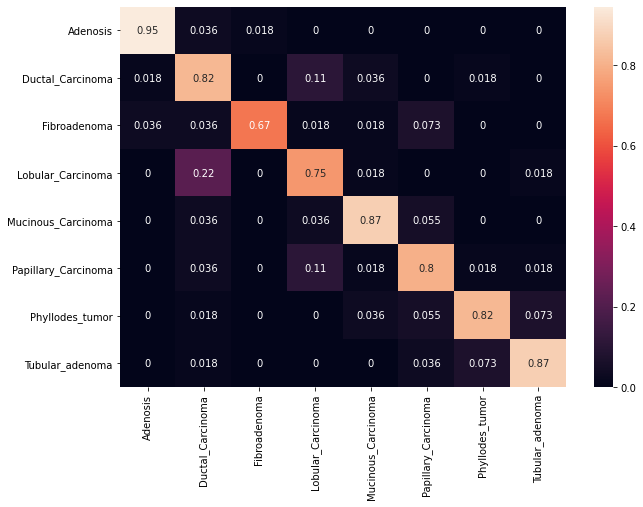

In [11]:
classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = a
df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

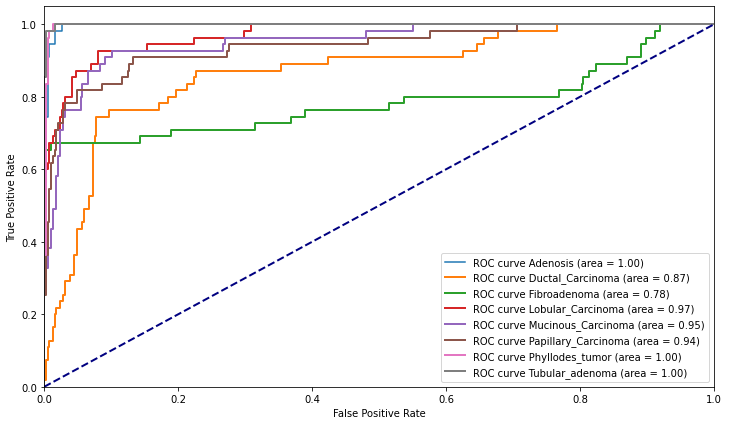

In [28]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

actuals, class_probabilities = test_class_probabilities(net, device, testloader, 0)
actuals1, class_probabilities1 = test_class_probabilities(net, device, testloader, 1)
actuals2, class_probabilities2 = test_class_probabilities(net, device, testloader, 2)
actuals3, class_probabilities3 = test_class_probabilities(net, device, testloader, 3)
actuals4, class_probabilities4 = test_class_probabilities(net, device, testloader, 4)
actuals5, class_probabilities5 = test_class_probabilities(net, device, testloader, 5)
actuals6, class_probabilities6 = test_class_probabilities(net, device, testloader, 6)
actuals7, class_probabilities7 = test_class_probabilities(net, device, testloader, 7)


fpr, tpr, _ = sklearn.metrics.roc_curve(actuals, np.nan_to_num(class_probabilities))
fpr1, tpr1, _ = sklearn.metrics.roc_curve(actuals1, np.nan_to_num(class_probabilities1))
fpr2, tpr2, _ = sklearn.metrics.roc_curve(actuals2, np.nan_to_num(class_probabilities2))
fpr3, tpr3, _ = sklearn.metrics.roc_curve(actuals3, np.nan_to_num(class_probabilities3))
fpr4, tpr4, _ = sklearn.metrics.roc_curve(actuals4, np.nan_to_num(class_probabilities4))
fpr5, tpr5, _ = sklearn.metrics.roc_curve(actuals5, np.nan_to_num(class_probabilities5))
fpr6, tpr6, _ = sklearn.metrics.roc_curve(actuals6, np.nan_to_num(class_probabilities6))
fpr7, tpr7, _ = sklearn.metrics.roc_curve(actuals7, np.nan_to_num(class_probabilities7))

roc_auc = sklearn.metrics.auc(fpr, tpr)
roc_auc1 = sklearn.metrics.auc(fpr1, tpr1)
roc_auc2 = sklearn.metrics.auc(fpr2, tpr2)
roc_auc3 = sklearn.metrics.auc(fpr3, tpr3)
roc_auc4 = sklearn.metrics.auc(fpr4, tpr4)
roc_auc5 = sklearn.metrics.auc(fpr5, tpr5)
roc_auc6 = sklearn.metrics.auc(fpr6, tpr6)
roc_auc7 = sklearn.metrics.auc(fpr7, tpr7)


plt.figure(figsize=(12,7))
lw = 2
plt.plot(fpr, tpr, label='ROC curve Adenosis (area = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1,lw=lw,label='ROC curve Ductal_Carcinoma (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, lw=lw,label='ROC curve Fibroadenoma (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, lw=lw,label='ROC curve Lobular_Carcinoma (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, lw=lw,label='ROC curve Mucinous_Carcinoma (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, lw=lw,label='ROC curve Papillary_Carcinoma (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, lw=lw,label='ROC curve Phyllodes_tumor (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, lw=lw,label='ROC curve Tubular_adenoma (area = %0.2f)' % roc_auc7)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()